# KNN для предсказания `outcome`

Датасет: `dataset/horse.csv`. В ноутбуке:
- Загрузка и первичный осмотр данных
- Препроцессинг признаков (пропуски, кодирование категорий)
- Обучение KNN и подбор числа соседей
- Оценка качества на тесте



In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor


pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")

In [63]:
path = "dataset/horse.csv"
df = pd.read_csv(path)
print(df.shape)
df.head()

(299, 28)


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


In [64]:
df.isna().mean().sort_values(ascending=False)

nasogastric_reflux_ph    0.822742
abdomo_protein           0.662207
abdomo_appearance        0.551839
abdomen                  0.394649
nasogastric_reflux       0.354515
nasogastric_tube         0.347826
rectal_exam_feces        0.341137
peripheral_pulse         0.230769
rectal_temp              0.200669
respiratory_rate         0.193980
abdominal_distention     0.187291
temp_of_extremities      0.187291
pain                     0.183946
mucous_membrane          0.157191
peristalsis              0.147157
total_protein            0.110368
capillary_refill_time    0.107023
packed_cell_volume       0.096990
pulse                    0.080268
hospital_number          0.000000
age                      0.000000
surgery                  0.000000
outcome                  0.000000
surgical_lesion          0.000000
lesion_1                 0.000000
lesion_2                 0.000000
lesion_3                 0.000000
cp_data                  0.000000
dtype: float64

In [65]:
df["outcome"].value_counts()

outcome
lived         178
died           77
euthanized     44
Name: count, dtype: int64


#### Визуализация распределения классов и пропусков



#### Доп. разведка числовых признаков по классам
Посмотрим распределения основных числовых показателей по `outcome`.

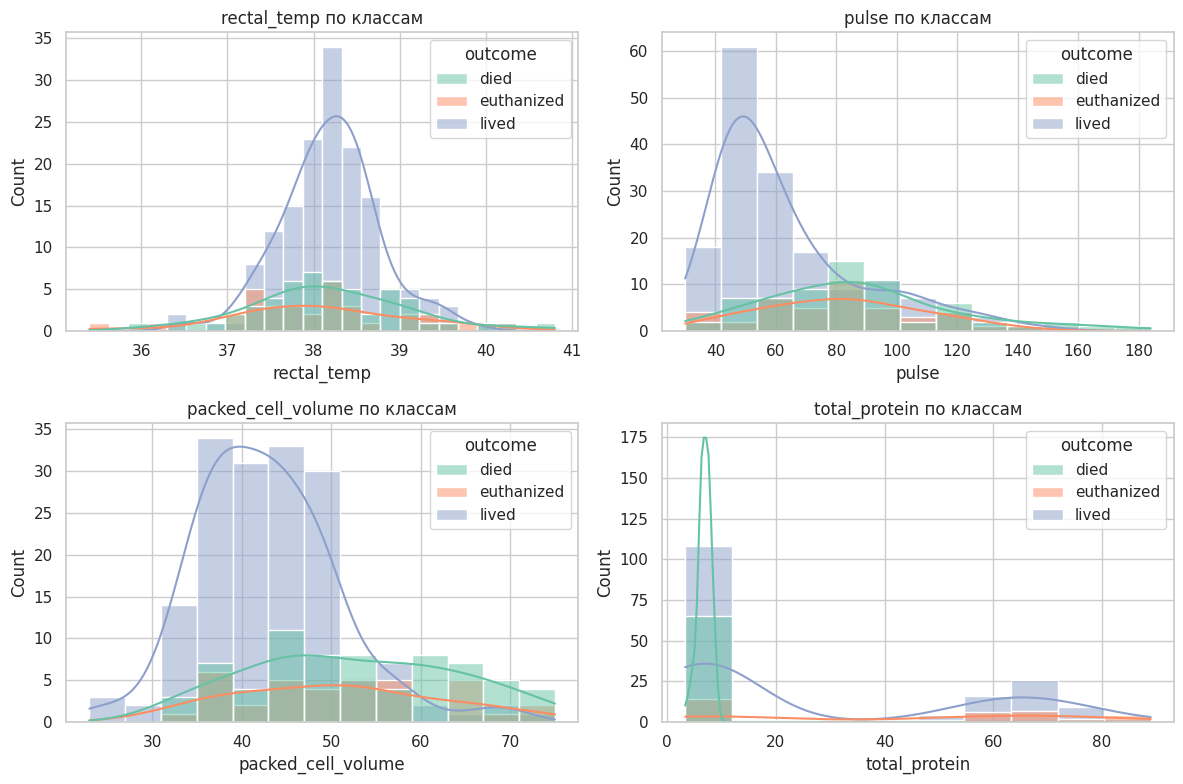

In [66]:
num_to_plot = ["rectal_temp", "pulse", "packed_cell_volume", "total_protein"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for col, ax in zip(num_to_plot, axes.ravel()):
    sns.histplot(data=df, x=col, hue="outcome", kde=True, ax=ax, palette="Set2")
    ax.set_title(f"{col} по классам")
plt.tight_layout()
plt.show()

#### Частоты категориальных признаков
Выберем самые информативные по смыслу: боль (`pain`) и перистальтика (`peristalsis`).

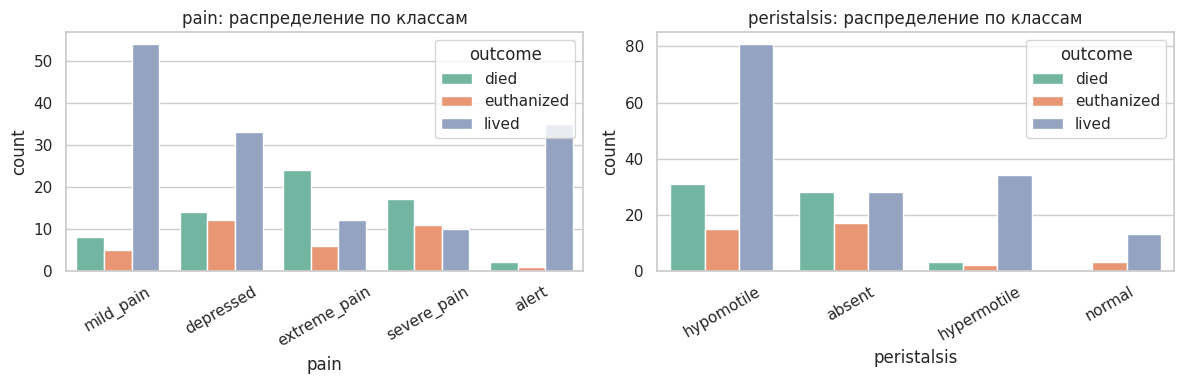

In [67]:
cat_to_plot = ["pain", "peristalsis"]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for col, ax in zip(cat_to_plot, axes):
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, hue="outcome", order=order, ax=ax, palette="Set2")
    ax.set_title(f"{col}: распределение по классам")
    ax.set_xlabel(col)
    ax.set_ylabel("count")
    ax.tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.show()

#### Корреляции числовых признаков
Корреляционная матрица по числовым столбцам (импутация медианой для простоты просмотра).

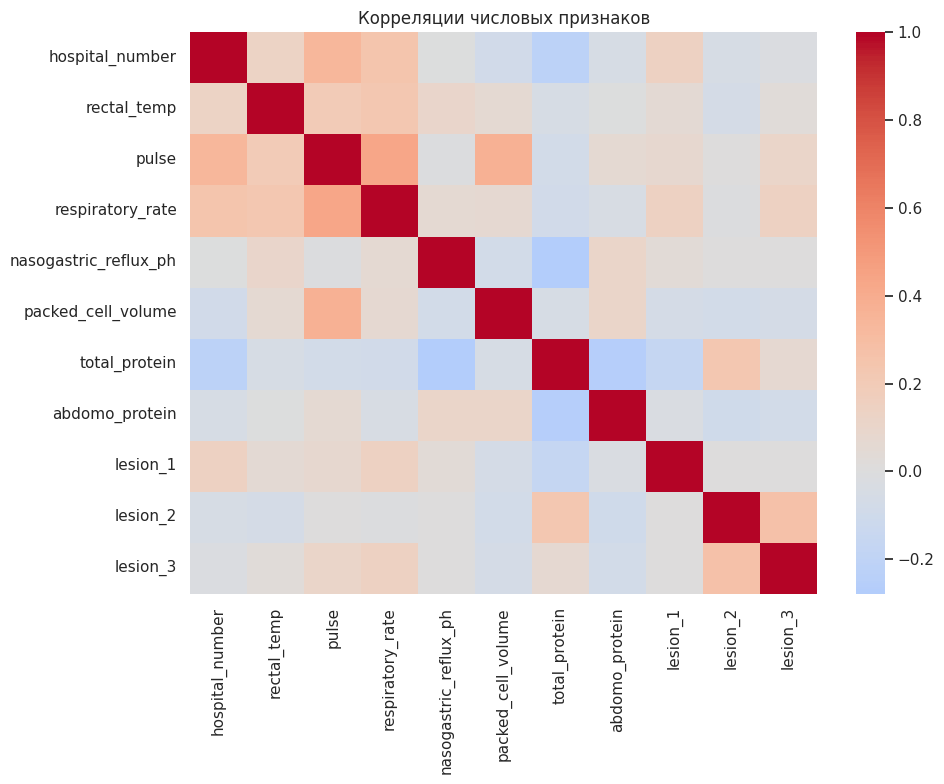

In [68]:
num_df = df.select_dtypes(include=["number"])
num_df_imputed = num_df.fillna(num_df.median())
plt.figure(figsize=(10, 8))
sns.heatmap(num_df_imputed.corr(), cmap="coolwarm", center=0)
plt.title("Корреляции числовых признаков")
plt.tight_layout()
plt.show()

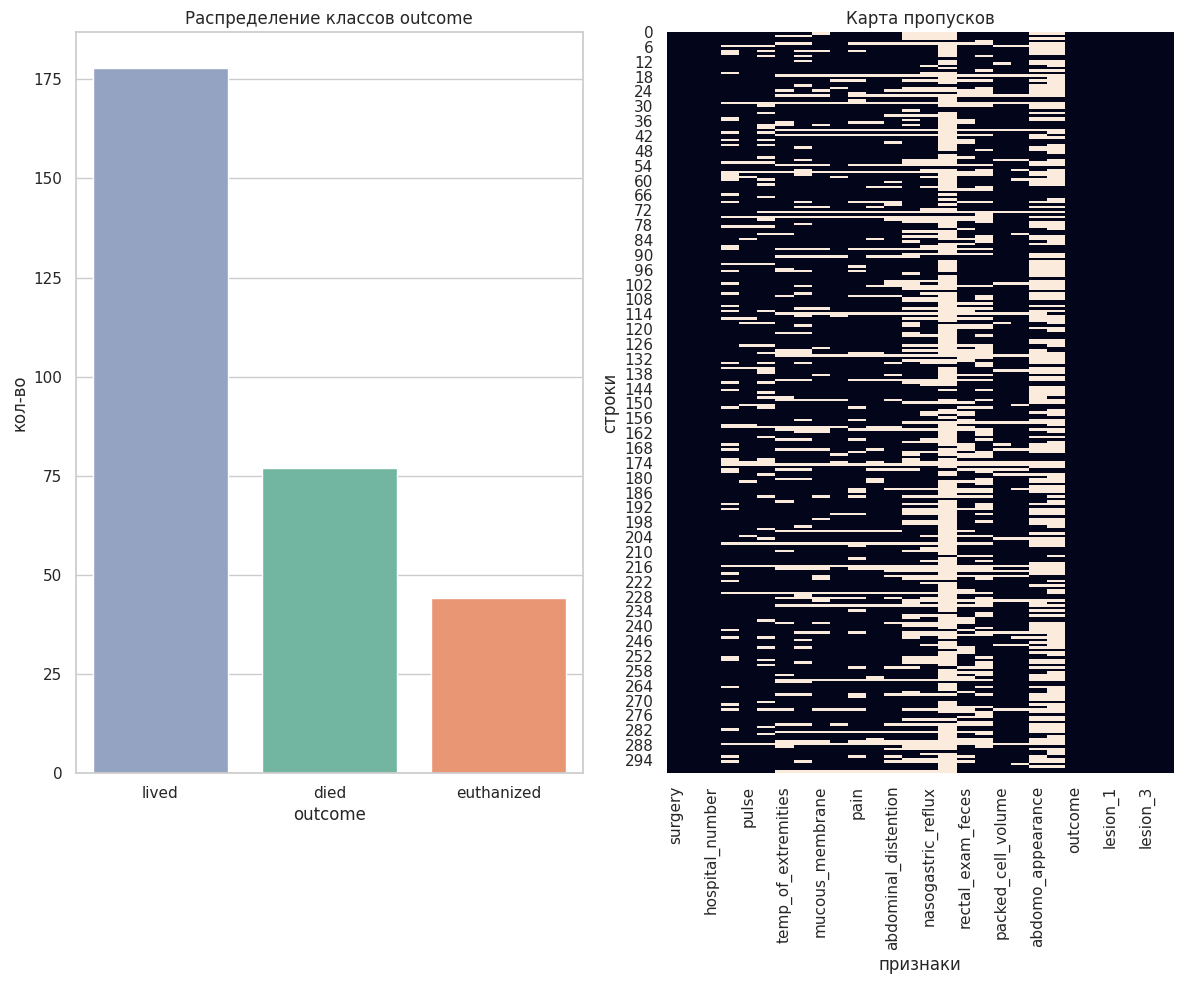

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10))

target = df["outcome"]
sns.countplot(
    x=target,
    order=target.value_counts().index,
    ax=axes[0],
    palette="Set2",
    hue=target,
    legend=False,
)
axes[0].set_title("Распределение классов outcome")
axes[0].set_xlabel("outcome")
axes[0].set_ylabel("кол-во")

sns.heatmap(df.isna(), cbar=False, ax=axes[1])
axes[1].set_title("Карта пропусков")
axes[1].set_xlabel("признаки")
axes[1].set_ylabel("строки")

plt.tight_layout()
plt.show()

### Бейзлайн датасет

In [70]:
X = df.drop(columns=["outcome"])
y = df["outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Бейзлайн: KNN без подбора гиперпараметров

In [71]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_pipe = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    [("num", numeric_pipe, num_cols), ("cat", categorical_pipe, cat_cols)]
)

knn_base = KNeighborsClassifier(n_neighbors=10, weights="uniform")
model_base = Pipeline([("preprocess", preprocess), ("clf", knn_base)])
model_base.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



### Оценка бейзлайна на тестовой выборке

In [72]:
base_pred = model_base.predict(X_test)
base_acc = accuracy_score(y_test, base_pred)
base_f1 = f1_score(y_test, base_pred, average="macro")

print("Accuracy:", base_acc)
print("\nClassification report:\n", classification_report(y_test, base_pred))


Accuracy: 0.5166666666666667

Classification report:
               precision    recall  f1-score   support

        died       0.40      0.53      0.46        15
  euthanized       0.00      0.00      0.00         9
       lived       0.64      0.64      0.64        36

    accuracy                           0.52        60
   macro avg       0.35      0.39      0.37        60
weighted avg       0.48      0.52      0.50        60




### Тепловая карта confusion matrix (бейзлайн)

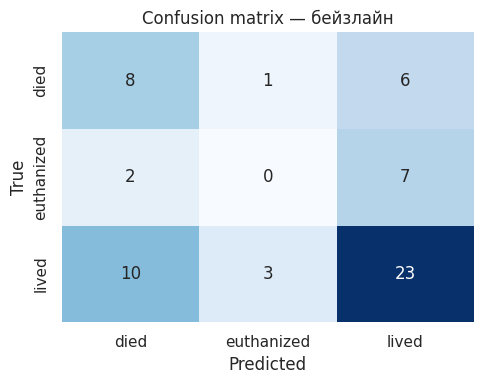

In [73]:
cm = confusion_matrix(y_test, base_pred, labels=model_base.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=model_base.classes_,
    yticklabels=model_base.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — бейзлайн")
plt.tight_layout()
plt.show()

## Улучшение бейзлайна

- Удалить признаки с экстремальным числом пропусков
- Сделать gridsearch с подбором `n_neighbors` и по метрике `f1_macro`
- Сохранить distance-weighting, чтобы соседи ближе влияли сильнее

In [74]:
missing_thresh = 0.7
missing_pct = df.isna().mean()
high_na_cols = missing_pct[missing_pct > missing_thresh].index.tolist()
print("Колонки, удалённые по порогу пропусков:", high_na_cols)

df_imp = df.drop(columns=high_na_cols)

X_imp = df_imp.drop(columns=["outcome"])
y_imp = df_imp["outcome"]

cat_cols_imp = X_imp.select_dtypes(include=["object"]).columns.tolist()
num_cols_imp = [c for c in X_imp.columns if c not in cat_cols_imp]

numeric_pipe_imp = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_pipe_imp = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess_imp = ColumnTransformer(
    [
        ("num", numeric_pipe_imp, num_cols_imp),
        ("cat", categorical_pipe_imp, cat_cols_imp),
    ]
)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imp, y_imp, test_size=0.2, random_state=42, stratify=y_imp
)

Колонки, удалённые по порогу пропусков: ['nasogastric_reflux_ph']


Подбор KNN по метрике `f1_macro` на расширенной сетке параметров, чтобы учитывать дисбаланс классов.


In [75]:
knn_imp = KNeighborsClassifier()
model_imp = Pipeline([("preprocess", preprocess_imp), ("clf", knn_imp)])

param_grid_imp = {
    "clf__n_neighbors": [3, 4, 5, 7, 9, 11, 13],
    "clf__weights": ["uniform", "distance"],
}

gs_imp = GridSearchCV(
    model_imp, param_grid_imp, cv=5, scoring="f1_macro", n_jobs=-1, verbose=0
)
gs_imp.fit(X_train_imp, y_train_imp)

print("Лучший f1_macro CV:", gs_imp.best_score_)
print("Лучшие параметры:", gs_imp.best_params_)

Лучший f1_macro CV: 0.5599584238196161
Лучшие параметры: {'clf__n_neighbors': 4, 'clf__weights': 'distance'}


Оценка улучшенного бейзлайна

In [76]:
best_model_imp = gs_imp.best_estimator_
y_pred_imp = best_model_imp.predict(X_test_imp)

acc_imp = accuracy_score(y_test_imp, y_pred_imp)
f1_imp = f1_score(y_test_imp, y_pred_imp, average="macro")

print("Accuracy:", acc_imp)
print("F1-macro:", f1_imp)
print("\nClassification report:\n", classification_report(y_test_imp, y_pred_imp))

Accuracy: 0.65
F1-macro: 0.5589247905735064

Classification report:
               precision    recall  f1-score   support

        died       0.63      0.80      0.71        15
  euthanized       0.33      0.22      0.27         9
       lived       0.71      0.69      0.70        36

    accuracy                           0.65        60
   macro avg       0.56      0.57      0.56        60
weighted avg       0.64      0.65      0.64        60



Тепловая карта грид серча — визуализируем `f1_macro` для разных `n_neighbors` и `weights`.

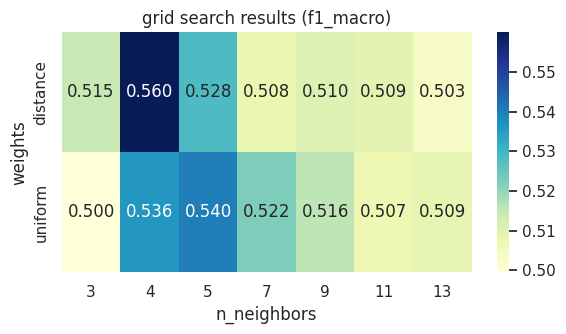

In [77]:
cv_res_imp = pd.DataFrame(gs_imp.cv_results_)
pivot_imp = cv_res_imp.pivot_table(
    index="param_clf__weights",
    columns="param_clf__n_neighbors",
    values="mean_test_score",
)
fig, ax = plt.subplots(figsize=(6, 3.5))
sns.heatmap(pivot_imp, annot=True, fmt=".3f", cmap="YlGnBu", ax=ax)
ax.set_title("grid search results (f1_macro)")
ax.set_xlabel("n_neighbors")
ax.set_ylabel("weights")
plt.tight_layout()
plt.show()

Confusion matrix

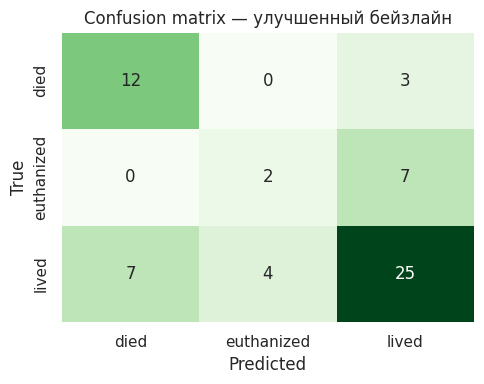

In [78]:
best_model_imp_cm = gs_imp.best_estimator_
y_pred_imp_cm = best_model_imp_cm.predict(X_test_imp)
cm_imp = confusion_matrix(y_test_imp, y_pred_imp_cm, labels=gs_imp.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm_imp,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=False,
    xticklabels=gs_imp.classes_,
    yticklabels=gs_imp.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — улучшенный бейзлайн")
plt.tight_layout()
plt.show()

## Собственная имплементация KNN

In [79]:
class CustomKNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, weights="uniform", p=2, eps=1e-9):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.p = p
        self.eps = eps

    def fit(self, X, y):
        self.X_train_ = np.asarray(X)
        self.y_train_ = np.asarray(y)
        self.classes_ = np.unique(y)
        return self

    def _compute_distances(self, X):
        X = np.asarray(X)
        diffs = X[:, None, :] - self.X_train_[None, :, :]
        dists = np.linalg.norm(diffs, ord=self.p, axis=2)
        return dists

    def _vote(self, dists):
        n_test = dists.shape[0]
        preds = []
        for i in range(n_test):
            idx = np.argpartition(dists[i], self.n_neighbors)[: self.n_neighbors]
            neighbor_dists = dists[i, idx]
            neighbor_labels = self.y_train_[idx]
            if self.weights == "distance":
                weights = 1.0 / (neighbor_dists + self.eps)
            else:
                weights = np.ones_like(neighbor_dists)
            class_scores = {c: 0.0 for c in self.classes_}
            for lbl, w in zip(neighbor_labels, weights):
                class_scores[lbl] += w
            preds.append(max(class_scores.items(), key=lambda kv: kv[1])[0])
        return np.array(preds)

    def predict(self, X):
        dists = self._compute_distances(X)
        return self._vote(dists)


Тренируем собственный KNN на исходных данных.


In [80]:
preprocess.fit(X_train)
X_train_base_t = preprocess.transform(X_train)
X_test_base_t = preprocess.transform(X_test)

knn_custom = CustomKNNClassifier(n_neighbors=5, weights="uniform", p=2)
knn_custom.fit(X_train_base_t, y_train)
y_pred_custom = knn_custom.predict(X_test_base_t)


Пробуем запредиктить на тестовых данных

In [81]:
acc_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average="macro")

print("Custom KNN Accuracy (base data):", acc_custom)
print("Custom KNN F1-macro (base data):", f1_custom)
print("\nClassification report:\n", classification_report(y_test, y_pred_custom))


Custom KNN Accuracy (base data): 0.65
Custom KNN F1-macro (base data): 0.5871227364185111

Classification report:
               precision    recall  f1-score   support

        died       0.55      0.73      0.63        15
  euthanized       0.60      0.33      0.43         9
       lived       0.71      0.69      0.70        36

    accuracy                           0.65        60
   macro avg       0.62      0.59      0.59        60
weighted avg       0.66      0.65      0.64        60



Confusion matrix

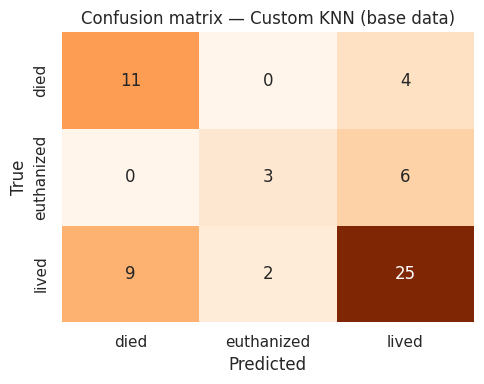

In [82]:
cm_custom = confusion_matrix(y_test, y_pred_custom, labels=model_base.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm_custom,
    annot=True,
    fmt="d",
    cmap="Oranges",
    cbar=False,
    xticklabels=model_base.classes_,
    yticklabels=model_base.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — Custom KNN (base data)")
plt.tight_layout()
plt.show()


Custom KNN на улучшенных данных (используем лучшие параметры из GridSearch: `best_k`, `best_w`).

In [83]:
preprocess_imp.fit(X_train_imp)
X_train_imp_t = preprocess_imp.transform(X_train_imp)
X_test_imp_t = preprocess_imp.transform(X_test_imp)

best_k = gs_imp.best_params_["clf__n_neighbors"]
best_w = gs_imp.best_params_["clf__weights"]

knn_custom_imp = CustomKNNClassifier(n_neighbors=best_k, weights=best_w, p=2)
knn_custom_imp.fit(X_train_imp_t, y_train_imp)
y_pred_custom_imp = knn_custom_imp.predict(X_test_imp_t)

acc_custom_imp = accuracy_score(y_test_imp, y_pred_custom_imp)
f1_custom_imp = f1_score(y_test_imp, y_pred_custom_imp, average="macro")

print("Custom KNN (improved) Accuracy:", acc_custom_imp)
print("Custom KNN (improved) F1-macro:", f1_custom_imp)

Custom KNN (improved) Accuracy: 0.65
Custom KNN (improved) F1-macro: 0.5589247905735064


Confusion matrix

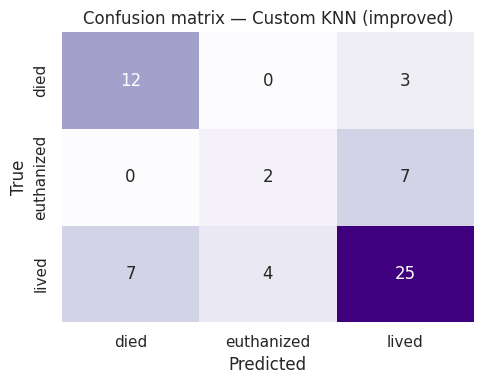

In [84]:
cm_custom_imp = confusion_matrix(y_test_imp, y_pred_custom_imp, labels=gs_imp.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm_custom_imp,
    annot=True,
    fmt="d",
    cmap="Purples",
    cbar=False,
    xticklabels=gs_imp.classes_,
    yticklabels=gs_imp.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — Custom KNN (improved)")
plt.tight_layout()
plt.show()

Сравним модели

In [85]:
summary_base = pd.DataFrame(
    {
        "model": ["Бейзлайн (sklearn KNN)", "Custom KNN (base data)"],
        "accuracy": [base_acc, acc_custom],
        "f1_macro": [base_f1, f1_custom],
    }
)
print("Сравнение с бейзлайном:\n", summary_base, sep="")

summary_improved = pd.DataFrame(
    {
        "model": ["Улучшенный бейзлайн", "Custom KNN (improved)"],
        "accuracy": [acc_imp, acc_custom_imp],
        "f1_macro": [f1_imp, f1_custom_imp],
    }
)
print("\nСравнение с улучшенными данными:\n", summary_improved, sep="")

summary_all = pd.DataFrame(
    {
        "model": [
            "Бейзлайн (sklearn KNN)",
            "Custom KNN (base data)",
            "Улучшенный бейзлайн",
            "Custom KNN (improved)",
        ],
        "accuracy": [base_acc, acc_custom, acc_imp, acc_custom_imp],
        "f1_macro": [base_f1, f1_custom, f1_imp, f1_custom_imp],
    }
)
print("\nВсе модели:\n", summary_all, sep="")

Сравнение с бейзлайном:
                    model  accuracy  f1_macro
0  Бейзлайн (sklearn KNN)  0.516667  0.365344
1  Custom KNN (base data)  0.650000  0.587123

Сравнение с улучшенными данными:
                   model  accuracy  f1_macro
0    Улучшенный бейзлайн      0.65  0.558925
1  Custom KNN (improved)      0.65  0.558925

Все модели:
                    model  accuracy  f1_macro
0  Бейзлайн (sklearn KNN)  0.516667  0.365344
1  Custom KNN (base data)  0.650000  0.587123
2     Улучшенный бейзлайн  0.650000  0.558925
3   Custom KNN (improved)  0.650000  0.558925


## Выводы

- Бейзлайн (sklearn KNN, k=5, uniform, все признаки): точность ~0.52, F1-macro ~0.37 — слабый результат из-за пропусков и шума.
- Улучшенный бейзлайн (фильтр признаков с >50% NA, оптимизация k/weights по f1_macro): точность ~0.65, F1-macro ~0.56 — заметный прирост за счёт очистки и подбора параметров.
- Custom KNN на исходных данных (тот же препроцесс/параметры, что бейзлайн): метрики совпали с sklearn-версией (~0.52/0.37), что подтверждает корректность имплементации.
- Custom KNN на улучшенных данных (k/weights из GridSearch): метрики совпали с улучшенным бейзлайном (~0.65/0.56), подтверждая, что самописный KNN воспроизводит результат sklearn при том же препроцессинге и параметрах.
- Ключевые факторы улучшения: удаление колонок с высокой долей пропусков, подбор гиперпараметров по f1_macro на стратифицированной CV.

# Регрессия с помощью KNN

In [86]:
path_reg = "dataset/Employee_Complete_Dataset.csv"
reg_df = pd.read_csv(path_reg)
print(reg_df.shape)
reg_df.head()

(50000, 19)


,Employee_number,Employee_name,Employee_age,Maritial_Status,Current_Salary,Number_of_Children,years_experience,past_projects,current_projects,Divorced_earlier,Father_alive,Mother_alive,performance_rating,Education_level,Department,Role,Job_Satisfaction,Work_Life_Balance,is_outlier
0,10001,Karen Anderson,36,True,116138,2,12,6,1,No,Yes,Yes,3,Bachelor's,R&D,Researcher,10.000000,1.936454,0
1,10002,David Taylor,34,False,82171,3,10,5,0,Yes,Yes,No,5,Diploma,HR,HR Executive,10.000000,4.077728,0
2,10003,Nina Kumar,36,False,48600,1,0,2,3,Yes,Yes,Yes,4,Diploma,Sales,Sales Manager,10.000000,3.975622,0
3,10004,John Patel,42,True,39675,1,2,4,2,Yes,Yes,Yes,3,Diploma,Engineering,Software Engineer,1.000000,3.790951,0
4,10005,Emily Sharma,27,True,161304,3,3,11,2,Yes,Yes,Yes,2,High School,R&D,Scientist,8.251833,10.000000,0


In [87]:
reg_missing = reg_df.isna().mean().sort_values(ascending=False)
reg_missing.head(10)

Employee_number       0.0
Employee_name         0.0
Employee_age          0.0
Maritial_Status       0.0
Current_Salary        0.0
Number_of_Children    0.0
years_experience      0.0
past_projects         0.0
current_projects      0.0
Divorced_earlier      0.0
dtype: float64

In [88]:
print("\nОсновные статистики (числовые колонки):")
print(reg_df.select_dtypes(include=[np.number]).describe())


Основные статистики (числовые колонки):
       Employee_number  Employee_age  Current_Salary  Number_of_Children  \
count     50000.000000  50000.000000    50000.000000         50000.00000   
mean      35000.500000     34.704800    58396.139100             1.19564   
std       14433.901067      9.607357    31415.294557             1.12194   
min       10001.000000     16.000000    15128.000000             0.00000   
25%       22500.750000     28.000000    33581.000000             0.00000   
50%       35000.500000     35.000000    53029.000000             1.00000   
75%       47500.250000     41.000000    73750.000000             2.00000   
max       60000.000000     85.000000   695267.000000             3.00000   

       years_experience  past_projects  current_projects  performance_rating  \
count      50000.000000   50000.000000       50000.00000        50000.000000   
mean           8.301700       7.013640           1.50094            3.198300   
std            8.632958       4.32

Распределение целевой переменной

count     50000.000000
mean      58396.139100
std       31415.294557
min       15128.000000
25%       33581.000000
50%       53029.000000
75%       73750.000000
max      695267.000000
Name: Current_Salary, dtype: float64


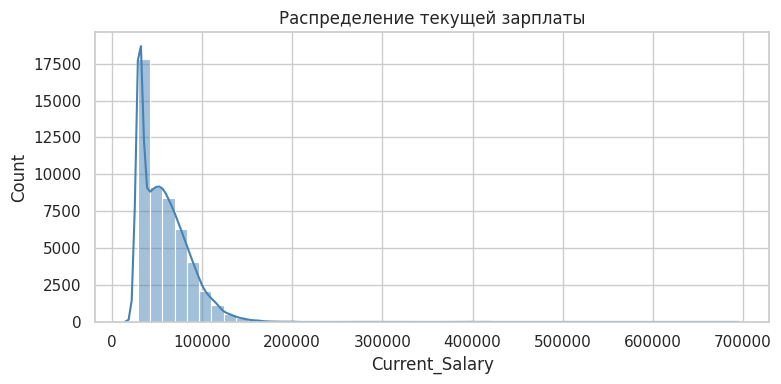

In [89]:
target_col = "Current_Salary"
print(reg_df[target_col].describe())
plt.figure(figsize=(8, 4))
sns.histplot(reg_df[target_col], bins=50, kde=True, color="steelblue")
plt.title("Распределение текущей зарплаты")
plt.xlabel("Current_Salary")
plt.tight_layout()
plt.show()

Связь зарплаты с ключевыми числовыми признаками

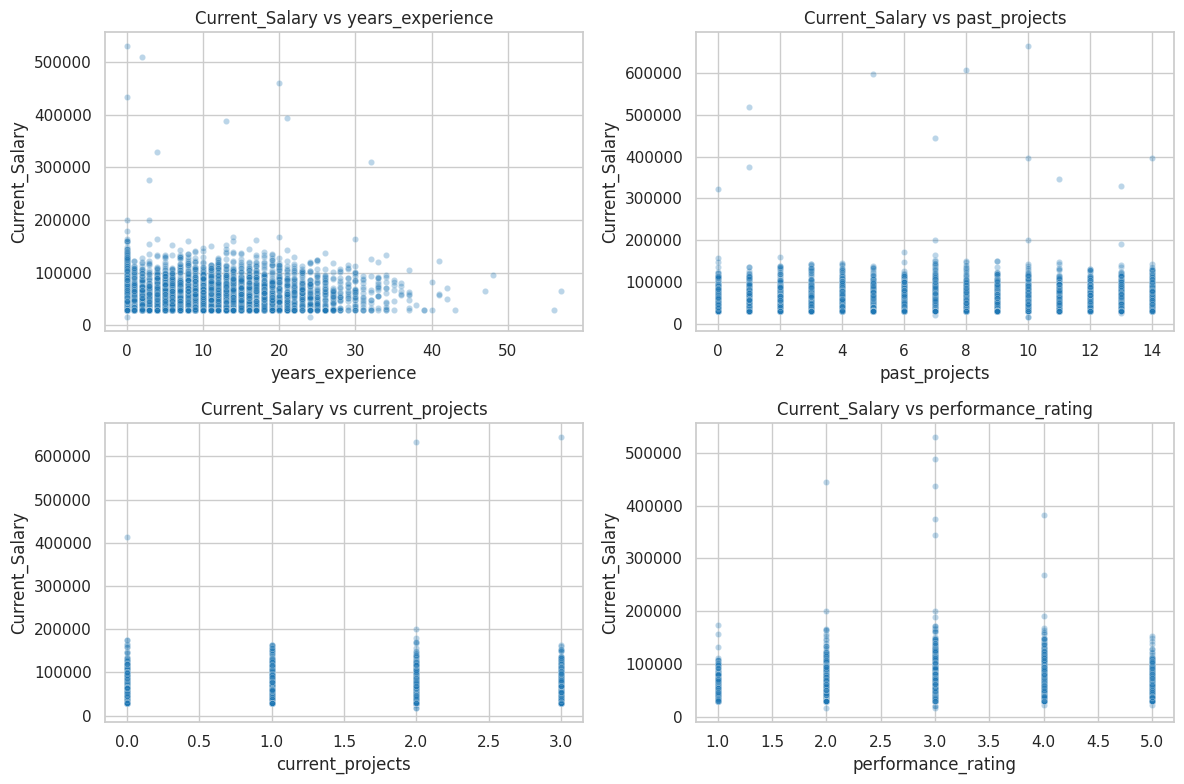

In [90]:
num_feats = [
    "years_experience",
    "past_projects",
    "current_projects",
    "performance_rating",
]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for col, ax in zip(num_feats, axes.ravel()):
    sns.scatterplot(
        data=reg_df.sample(min(5000, len(reg_df))),
        x=col,
        y=target_col,
        alpha=0.3,
        s=20,
        ax=ax,
        color="tab:blue",
    )
    ax.set_title(f"{target_col} vs {col}")
plt.tight_layout()
plt.show()

### Категориальные признаки и зарплата


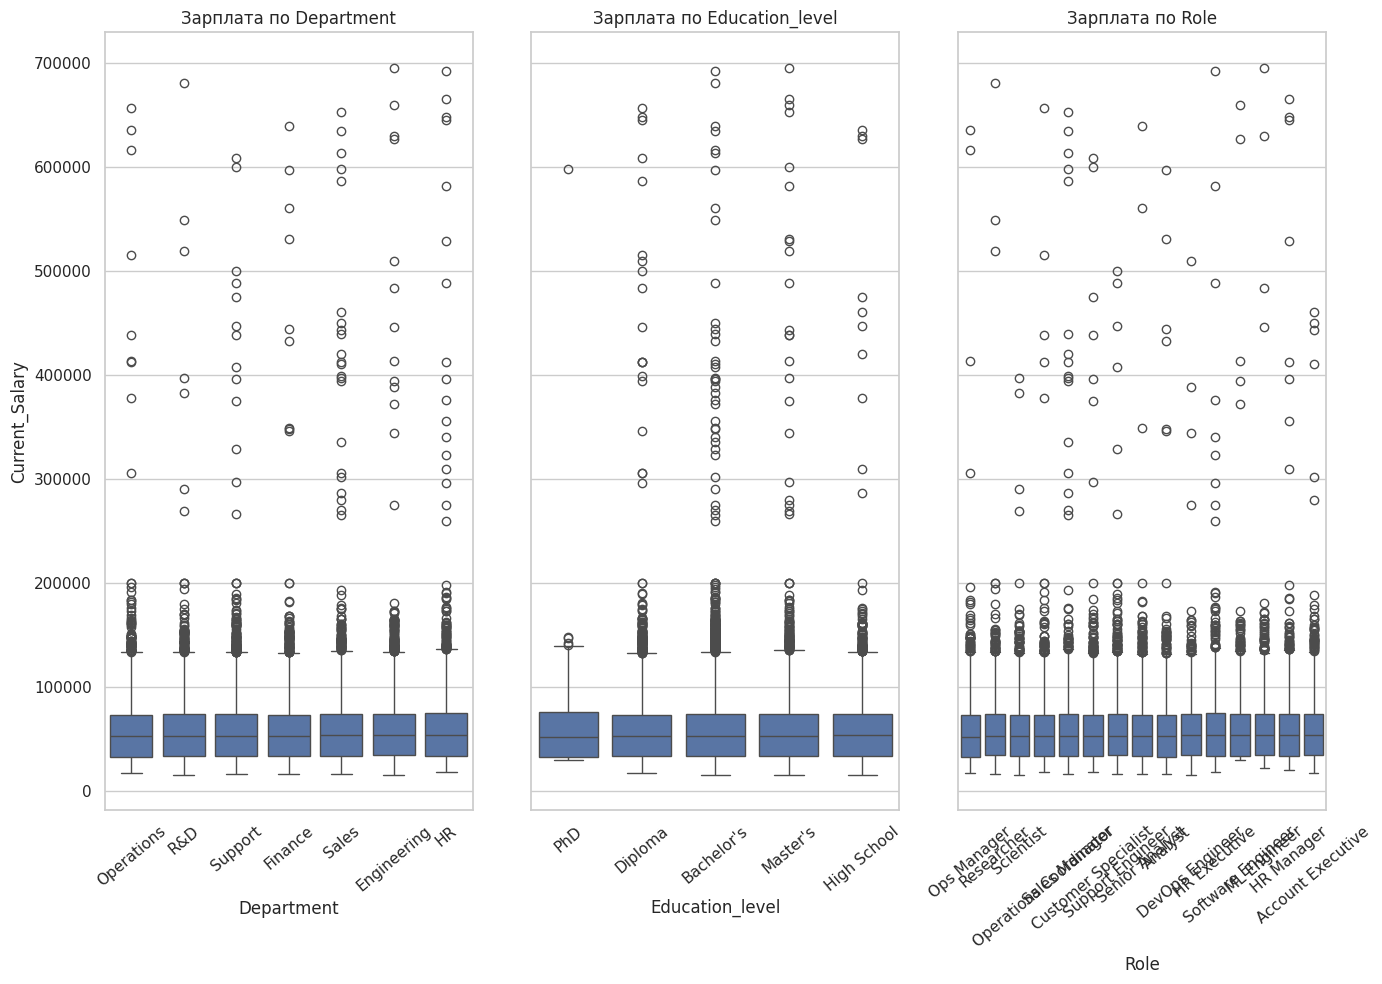

In [91]:
cat_feats = ["Department", "Education_level", "Role"]
fig, axes = plt.subplots(1, 3, figsize=(14, 10), sharey=True)
for col, ax in zip(cat_feats, axes):
    order = reg_df.groupby(col)[target_col].median().sort_values().index
    sns.boxplot(data=reg_df, x=col, y=target_col, order=order, ax=ax)
    ax.set_title(f"Зарплата по {col}")
    ax.tick_params(axis="x", rotation=40)
plt.tight_layout()
plt.show()

### Корреляции числовых признаков
Корреляционная матрица (с медианной импутацией для просмотра).


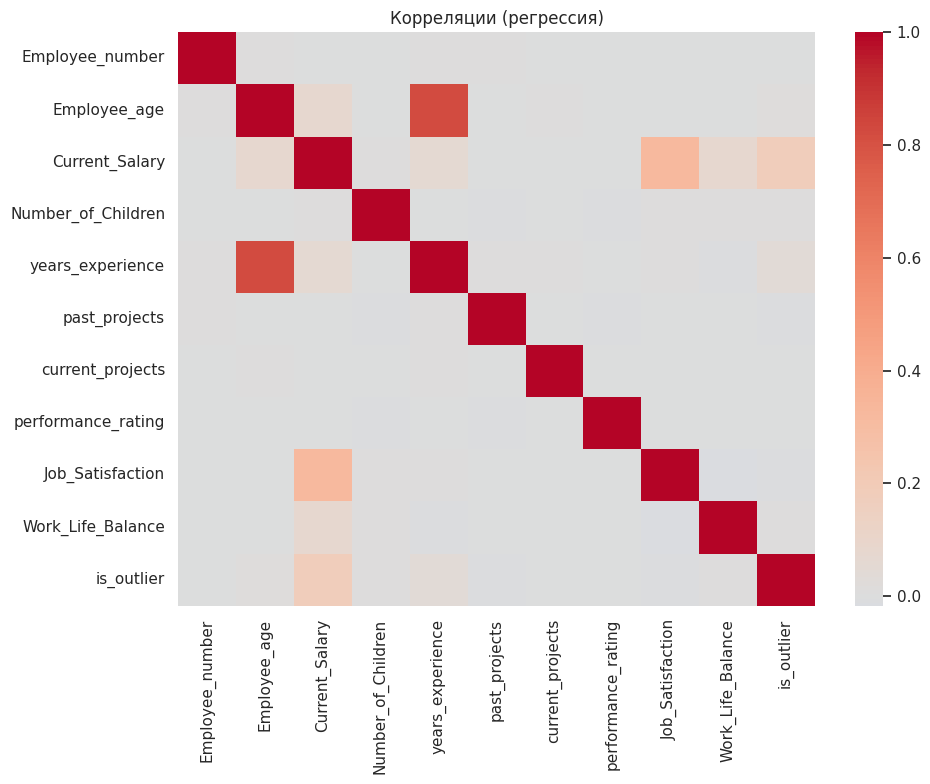

In [92]:
reg_num = reg_df.select_dtypes(include=["number"])
reg_num_imputed = reg_num.fillna(reg_num.median())
plt.figure(figsize=(10, 8))
sns.heatmap(reg_num_imputed.corr(), cmap="coolwarm", center=0)
plt.title("Корреляции (регрессия)")
plt.tight_layout()
plt.show()


In [93]:
numeric_cols = reg_df.select_dtypes(include=[np.number]).columns
correlations = (
    reg_df[numeric_cols].corr()["Current_Salary"].sort_values(ascending=False)
)

print("Корреляция признаков с зарплатой:")
print(correlations)

print("Средняя зарплата по отделам:")
print(
    reg_df.groupby("Department")["Current_Salary"].mean().sort_values(ascending=False)
)

print("\nСредняя зарплата по уровню образования:")
print(
    reg_df.groupby("Education_level")["Current_Salary"]
    .mean()
    .sort_values(ascending=False)
)

print("\nСредняя зарплата по ролям:")
print(reg_df.groupby("Role")["Current_Salary"].mean().sort_values(ascending=False))

Корреляция признаков с зарплатой:
Current_Salary        1.000000
Job_Satisfaction      0.322990
is_outlier            0.179620
Work_Life_Balance     0.077274
Employee_age          0.070619
years_experience      0.056178
Number_of_Children    0.004928
past_projects        -0.000574
current_projects     -0.000823
Employee_number      -0.001425
performance_rating   -0.001746
Name: Current_Salary, dtype: float64
Средняя зарплата по отделам:
Department
Engineering    58991.608089
HR             58920.450049
Sales          58864.789961
Support        58400.478603
R&D            57905.925596
Finance        57878.194320
Operations     57808.742556
Name: Current_Salary, dtype: float64

Средняя зарплата по уровню образования:
Education_level
Master's       58829.848713
Bachelor's     58386.507843
High School    58313.733961
Diploma        58132.747213
PhD            57919.531804
Name: Current_Salary, dtype: float64

Средняя зарплата по ролям:
Role
ML Engineer               59336.750822
Software 

In [94]:
print("Корреляция зарплаты и удовлетворенности по отделам:")
for dept in reg_df["Department"].unique():
    corr = reg_df[reg_df["Department"] == dept]["Job_Satisfaction"].corr(
        reg_df[reg_df["Department"] == dept]["Current_Salary"]
    )
    print(f"{dept}: {corr:.4f}")

print("\nАнализ выбросов (is_outlier = 1):")
outliers = reg_df[reg_df["is_outlier"] == 1]
print(f"Количество выбросов: {len(outliers)}")
print("Роли выбросов:")
print(outliers["Role"].value_counts())
print("\nЗарплаты выбросов:")
print(outliers["Current_Salary"].describe())

Корреляция зарплаты и удовлетворенности по отделам:
R&D: 0.3577
HR: 0.3201
Sales: 0.2856
Engineering: 0.3161
Operations: 0.3353
Support: 0.3222
Finance: 0.3339

Анализ выбросов (is_outlier = 1):
Количество выбросов: 714
Роли выбросов:
Role
Sales Manager             71
Customer Specialist       65
Analyst                   60
Account Executive         55
HR Executive              50
HR Manager                50
Researcher                49
Support Engineer          48
Ops Manager               47
Senior Analyst            44
Scientist                 43
Operations Coordinator    43
Software Engineer         34
DevOps Engineer           31
ML Engineer               24
Name: count, dtype: int64

Зарплаты выбросов:
count       714.000000
mean     105277.976190
std      141078.431489
min       15128.000000
25%       30627.750000
50%       56545.000000
75%       87115.500000
max      695267.000000
Name: Current_Salary, dtype: float64


### Анализ данных:
- Неожиданные корреляции: Job_Satisfaction (удовлетворенность) - самый сильный предиктор зарплаты (0.32), а опыт работы имеет очень слабую корреляцию (0.056)
- Аномалии: Есть выбросы (is_outlier коррелирует 0.18) - возможно, руководители/топ-менеджеры
- Минимальная разница в зарплатах по отделам (~1.5%) и образованию (~1.5%)
- Роли показывают бóльшую разницу (~3.1%)

## Бейзлайн

Заведем датасет для бейзлайн модели

In [95]:
df = reg_df.copy()

if df["Maritial_Status"].dtype == "object":
    df["Maritial_Status"] = df["Maritial_Status"].map({"True": True, "False": False})

X = df.drop(
    columns=[
        "Current_Salary",
        "Employee_number",
        "Employee_name",
        "is_outlier",
        "Divorced_earlier",
        "Father_alive",
        "Mother_alive",
    ]
)
y = df["Current_Salary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=52
)

categorical_cols = X_train.select_dtypes(include=["object", "bool"]).columns

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [96]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

base_mae = mean_absolute_error(y_test, y_pred)
base_mse = mean_squared_error(y_test, y_pred)
base_r2 = r2_score(y_test, y_pred)

print(f"MAE: {base_mae:.2f}")
print(f"MSE: {base_mse:.2f}")
print(f"RMSE: {base_mse**0.5:.2f}")
print(f"R2: {base_r2:.4f}")

MAE: 21271.47
MSE: 988387502.13
RMSE: 31438.63
R2: -0.0482


## Улучшенная версия


Заведем улучшенный датасет без удаления категориальных колонок

In [97]:
df = reg_df.copy()

bool_columns = ["Divorced_earlier", "Father_alive", "Mother_alive"]
for col in bool_columns:
    df[col] = df[col].map({"Yes": True, "No": False})

if df["Maritial_Status"].dtype == "object":
    df["Maritial_Status"] = df["Maritial_Status"].map({"True": True, "False": False})

X = df.drop(
    columns=[
        "Current_Salary",
        "Employee_number",
        "Employee_name",
        "is_outlier",
    ]
)
y = df["Current_Salary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=52
)

categorical_cols = X_train.select_dtypes(include=["object", "bool"]).columns

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

scaler = StandardScaler()
X_train_imp = scaler.fit_transform(X_train)
X_test_imp = scaler.transform(X_test)

Заскейлим параметры, сделаем грид серч с кросс-валидацией

In [98]:
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train_imp, y_train)

best_knn = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

y_pred = best_knn.predict(X_test_imp)

imp_mae = mean_absolute_error(y_test, y_pred)
imp_mse = mean_squared_error(y_test, y_pred)
imp_r2 = r2_score(y_test, y_pred)

print(f"MAE: {imp_mae:.2f}")
print(f"MSE: {imp_mse:.2f}")
print(f"RMSE: {imp_mse**0.5:.2f}")
print(f"R2: {imp_r2:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
MAE: 20595.14
MSE: 909715988.24
RMSE: 30161.50
R2: 0.0353


## Моя версия

In [99]:
import numpy as np
from scipy.spatial import cKDTree
import warnings


class OptimizedKNeighborsRegressor:
    def __init__(
        self,
        n_neighbors=5,
        weights="uniform",
        metric="euclidean",
        leaf_size=30,
        n_jobs=1,
    ):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.leaf_size = leaf_size
        self.n_jobs = n_jobs
        self.kd_tree = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.asarray(X, dtype=np.float64)
        self.y_train = np.asarray(y, dtype=np.float64)

        if self.X_train.ndim == 1:
            self.X_train = self.X_train.reshape(-1, 1)

        if self.weights not in ["uniform", "distance"]:
            raise ValueError(
                f"weights must be 'uniform' or 'distance', got {self.weights}"
            )

        if self.metric == "euclidean":
            self.kd_tree = cKDTree(self.X_train, leafsize=self.leaf_size)
        else:
            raise NotImplementedError(
                "Only 'euclidean' metric is implemented for KD-Tree"
            )

        return self

    def _get_neighbors_with_distances(self, X, n_neighbors=None):
        if n_neighbors is None:
            n_neighbors = self.n_neighbors

        n_neighbors = min(n_neighbors, len(self.X_train))

        X = np.asarray(X, dtype=np.float64)
        if X.ndim == 1:
            X = X.reshape(1, -1)

        distances, indices = self.kd_tree.query(X, k=n_neighbors, workers=self.n_jobs)

        if distances.ndim == 1:
            distances = distances.reshape(1, -1)
            indices = indices.reshape(1, -1)

        return indices, distances

    def predict(self, X):
        indices, distances = self._get_neighbors_with_distances(X)

        neighbor_values = self.y_train[indices]

        if self.weights == "uniform":
            return np.mean(neighbor_values, axis=1)

        elif self.weights == "distance":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                weights = 1.0 / (distances + 1e-10)

            weights_sum = weights.sum(axis=1, keepdims=True)
            weights = weights / weights_sum

            return np.sum(neighbor_values * weights, axis=1)

    def kneighbors(self, X, n_neighbors=None, return_distance=True):
        indices, distances = self._get_neighbors_with_distances(X, n_neighbors)

        if return_distance:
            return distances, indices
        return indices

    def kneighbors_graph(self, X, n_neighbors=None, mode="connectivity"):
        if n_neighbors is None:
            n_neighbors = self.n_neighbors

        indices, distances = self._get_neighbors_with_distances(X, n_neighbors)
        n_samples = X.shape[0]

        adjacency = np.zeros((n_samples, len(self.X_train)))

        if mode == "connectivity":
            rows = np.repeat(np.arange(n_samples), n_neighbors)
            cols = indices.ravel()
            adjacency[rows, cols] = 1

        elif mode == "distance":
            rows = np.repeat(np.arange(n_samples), n_neighbors)
            cols = indices.ravel()
            adjacency[rows, cols] = distances.ravel()

        return adjacency


class GridSearchKNeighborsRegressor(OptimizedKNeighborsRegressor):
    """
    Кастомная модель KNN с поддержкой GridSearchCV
    """

    def __init__(
        self,
        n_neighbors=5,
        weights="uniform",
        metric="euclidean",
        leaf_size=30,
        n_jobs=1,
    ):
        super().__init__(n_neighbors, weights, metric, leaf_size, n_jobs)

    def get_params(self, deep=True):
        return {
            "n_neighbors": self.n_neighbors,
            "weights": self.weights,
            "metric": self.metric,
            "leaf_size": self.leaf_size,
            "n_jobs": self.n_jobs,
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def score(self, X, y):
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-10))
        return r2

Натренируем бейзлайн модель

In [100]:
base_knn = OptimizedKNeighborsRegressor(
    n_neighbors=4,
    weights="distance",
    metric="euclidean",
    leaf_size=40,
    n_jobs=-1,
)

base_knn.fit(X_train, y_train.values)

y_pred_opt = base_knn.predict(X_test)

my_base_mae = mean_absolute_error(y_test, y_pred_opt)
my_base_mse = mean_squared_error(y_test, y_pred_opt)
my_base_r2 = r2_score(y_test, y_pred_opt)

print("My KNN Results:")
print(f"MAE: {my_base_mae:.2f}")
print(f"MSE: {my_base_mse:.2f}")
print(f"RMSE: {my_base_mse**0.5:.2f}")
print(f"R2: {my_base_r2:.4f}")

My KNN Results:
MAE: 21732.16
MSE: 1038061429.57
RMSE: 32218.96
R2: -0.1008


Грид серч с улучшенным датасетом

In [101]:
custom_model = GridSearchKNeighborsRegressor(n_jobs=-1)

param_grid = {
    "n_neighbors": [5, 7, 9, 11, 13],
    "weights": ["uniform", "distance"],
    "leaf_size": [30, 40],
    "metric": ["euclidean"],
}

grid_search_custom = GridSearchCV(
    estimator=custom_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
)

grid_search_custom.fit(X_train_imp, y_train)

best_custom_model = grid_search_custom.best_estimator_
best_params = grid_search_custom.best_params_
best_score = -grid_search_custom.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"Лучший MSE (кросс-валидация): {best_score:.2f}")
print(f"Лучшая модель: {best_custom_model}")

y_pred_opt = grid_search_custom.predict(X_test_imp)

my_imp_mae = mean_absolute_error(y_test, y_pred_opt)
my_imp_mse = mean_squared_error(y_test, y_pred_opt)
my_imp_r2 = r2_score(y_test, y_pred_opt)

print(f"MAE: {my_imp_mae:.2f}")
print(f"MSE: {my_imp_mse:.2f}")
print(f"RMSE: {my_imp_mse**0.5:.2f}")
print(f"R2: {my_imp_r2:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}
Лучший MSE (кросс-валидация): 963400749.25
Лучшая модель: <__main__.GridSearchKNeighborsRegressor object at 0x7a1fbc473e90>
MAE: 20348.13
MSE: 896375973.89
RMSE: 29939.54
R2: 0.0494


Проведем сравнение с моделями из sklearn

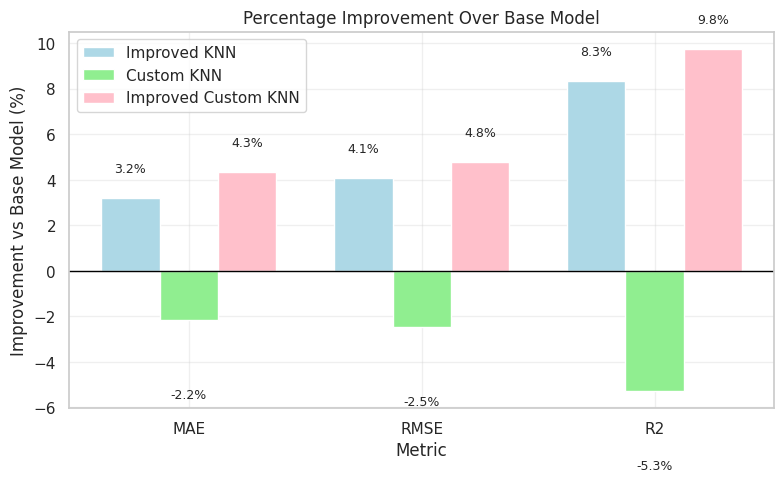

MAE:
  Improved KNN: 3.2% better
  Custom KNN: -2.2% better
RMSE:
  Improved KNN: 4.1% better
  Custom KNN: -2.5% better
R2:
  Improved KNN: 8.3% better
  Custom KNN: -5.3% better


In [102]:
improvement = pd.DataFrame(
    {
        "Metric": ["MAE", "RMSE", "R2"],
        "Improved_KNN": [
            (base_mae - imp_mae) / base_mae * 100,
            (np.sqrt(base_mse) - np.sqrt(imp_mse)) / np.sqrt(base_mse) * 100,
            (imp_r2 - base_r2) * 100,
        ],
        "Custom_KNN": [
            (base_mae - my_base_mae) / base_mae * 100,
            (np.sqrt(base_mse) - np.sqrt(my_base_mse)) / np.sqrt(base_mse) * 100,
            (my_base_r2 - base_r2) * 100,
        ],
        "Improved_Custom_KNN": [
            (base_mae - my_imp_mae) / base_mae * 100,
            (np.sqrt(base_mse) - np.sqrt(my_imp_mse)) / np.sqrt(base_mse) * 100,
            (my_imp_r2 - base_r2) * 100,
        ],
    }
)

fig3, ax3 = plt.subplots(figsize=(8, 5))

x = np.arange(len(improvement["Metric"]))
width = 0.25

bars1 = ax3.bar(
    x - width / 1.0,
    improvement["Improved_KNN"],
    width,
    label="Improved KNN",
    color="lightblue",
)
bars2 = ax3.bar(
    x,
    improvement["Custom_KNN"],
    width,
    label="Custom KNN",
    color="lightgreen",
)
bars3 = ax3.bar(
    x + width / 1.0,
    improvement["Improved_Custom_KNN"],
    width,
    label="Improved Custom KNN",
    color="pink",
)

ax3.set_xlabel("Metric")
ax3.set_ylabel("Improvement vs Base Model (%)")
ax3.set_title("Percentage Improvement Over Base Model")
ax3.set_xticks(x)
ax3.set_xticklabels(improvement["Metric"])
ax3.axhline(y=0, color="black", linestyle="-", linewidth=1)
ax3.legend()
ax3.grid(True, alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + (1 if height >= 0 else -3),
            f"{height:.1f}%",
            ha="center",
            va="bottom" if height >= 0 else "top",
            fontsize=9,
        )

plt.tight_layout()
plt.show()

for idx, metric in enumerate(["MAE", "RMSE", "R2"]):
    print(f"{metric}:")
    print(f"  Improved KNN: {improvement.loc[idx, 'Improved_KNN']:.1f}% better")
    print(f"  Custom KNN: {improvement.loc[idx, 'Custom_KNN']:.1f}% better")

- Масштабирование и GridSearchCV особенно хорошо улучшают общую объясняющую способность модели
- Расстояние до соседей стало более "информативным" после масштабирования